## Effect of Forward Motion Compensation on L2 $\mathrm{XCO_2}$ and $\mathrm{XCH_4}$ precision

This notebook  shows the effect of FMC on the TANGO-Carbon L2 precision. Note that for the proxy product, the relative L2 precision is the same for $\mathrm XCO_2$ and $\mathrm XCH_4$. Therefore, we focus on the $\mathrm XCO_2$ precision only.

The simulations use the exposure time to account for both co-adding and forward motion compensaetion. 
We use the relation provided in Ryan's excel sheet using for the exposure time<br>
$t_\mathrm{exp} = \frac{t_\mathrm{dwell}}{n_{coadd}} - 0.004$  <br>
with the dwell time <br>
$ t_\mathrm{dwell} = 2*\frac{\Delta \mathrm{ALT}}{v_\mathrm{ground}} * \mathrm{fmc}$  <br> 

Simulations are performed for the following TANGO-Carbon specific parameter settings:<br>
|parameter           | note                              |
|--------------------|-----------------------------------|
|$\Delta \mathrm{ALT} = 150$ m  | instanteneous FOV at ground level in ALT direction            |
|$v_\mathrm{ground}= 7061$ m/s | ground velocity         |
|$n_{coadd}$ = 5, 10  | coadding factor                   |
|$fmc = 1,2,3,4,5$   |forward motion compensation factor.|




In [ ]:
import sys
sys.path.append("/home/jochen/pythonenvs/tangoendtoend/lib64/python3.11/site-packages")
import os
import yaml
import numpy as np
from netCDF4 import Dataset
from copy import deepcopy
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import matplotlib.pyplot as plt

# define  path to search for module
sys.path.append("/home/jochen/TANGO_E2ES/EndtoEndProject/end_to_end/")
os.chdir("/home/jochen/TANGO_E2ES/EndtoEndProject/end_to_end/examples/exp13_fmc_precision/")

### 2. Import teds modules

In [ ]:
from teds.gm.gm import geometry_module
from teds.sgm import geoscene_generation
from teds.sgm import Carbon_radiation_scene_generation
from teds.im import run_instrument_model
from teds.l1al1b import run_l1al1b
from teds.l1l2.l1bl2 import level1b_to_level2_processor

### 3. Set overall path

In [ ]:
path  = '/home/jochen/TANGO_E2ES/EndtoEndProject/data/interface_data/'

### 4. GM

In [ ]:
#In this configurationn, the gm does not include solar and viewing geometry. It is easier to define them within the notebook
gm_config= yaml.safe_load(open('./settings/gm_config.yaml'))
#we use the nact dimension to simulate scenes with different scaling factors s and the geometry of Lref
nact = 500 
gm_config['scene_spec'] = {}
gm_config['scene_spec']['sza'] = np.zeros(nact) + 70.
gm_config['scene_spec']['saa'] = np.zeros(nact) 
gm_config['scene_spec']['vza'] = np.zeros(nact) 
gm_config['scene_spec']['vaa'] = np.zeros(nact) 

geometry_module(gm_config)


[14:05:27] Generating detector image timestamps
[14:05:27] Generating geometry for 500 across track locations


#########################
# Tango geometry module #
#########################
Version                 : 0.0.1
Commit hash             : 7d395538
Date and timezone       : 2025 February 22 Sat
Contacts                : raullaasner@gmail.com
                          bitbucket.org/sron_earth/teds/issues (request permission)
Host system             : Linux 6.8.0-52-generic


###########
# Success #
###########


#### 5. SGM-GEO

In [ ]:
nact = 500
albedo = np.ones(nact)*0.15
sgmgeo_config= yaml.safe_load(open('./settings/sgmgeo_config.yaml'))
sgmgeo_config['scene_spec']={}
sgmgeo_config['scene_spec']['albedo'] = albedo
geoscene_generation(sgmgeo_config)


###########
# Success #
###########


/home/jochen/TANGO_E2ES/EndtoEndProject/end_to_end/teds/gm/vincenty.py:62: RuntimeWarning: invalid value encountered in divide
  cU1 * cU2 * slam / sin_sigma)


#### 6. SGM-RAD

In [ ]:
sgmrad_config= yaml.safe_load(open('./settings/sgmrad_config.yaml'))
Carbon_radiation_scene_generation(sgmrad_config)

Radiative tranfer simulation...


100%|██████████| 1/1 [00:18<00:00, 18.84s/it]



###########
# Success #
###########


### 7. Loop IM, L1AL1B and L2 processor over different FMCs

Run the instrument model for each scaled scenes using a seperate call 

In [ ]:
# exposure time as a function of fmc and coadding extracted from Ryan's excel sheet 
# first row for coadd=5, second row for coadd = 10.
expot = [[0.0044975, 0.0129951, 0.0214916, 0.0299902, 0.0384877],
         [0.0002488, 0.0044975, 0.0087463, 0.0129951, 0.0172439]]
coadd = [5, 10] #coadding 

for iadd in range(2):
    for fmc in range(5):

        cfmc = str_bcoeff = "%.1f" % (fmc)
        ccoadd = str_bcoeff = "%.1f" % (coadd[iadd])
        # instrument model
        im_config= yaml.safe_load(open('./settings/im_config.yaml'))
        im_config['detector']['exposure_time'] = expot[iadd][fmc]
        im_config['detector']['nr_coadditions'] = coadd[iadd]
        print(type(im_config['detector']['exposure_time']))
        run_instrument_model(im_config)

        # l1al1b processor
        l1al1b_config= yaml.safe_load(open('./settings/l1al1b_config.yaml'))
        l1al1b_config['io']['l1b'] = path+'level1b/Tango_Carbon_l1b_exp13_fmc'+cfmc+'_coadd'+ccoadd+'.nc'
        l1al1b_config['stray']['van_cittert_steps']= 4
        run_l1al1b(l1al1b_config)

        # l2 processor
        l1bl2_config= yaml.safe_load(open('./settings/l1bl2_config.yaml'))
        l1bl2_config['io_files']['output_l2'] = path+'level2/Tango_Carbon_l2_exp13_fmc'+cfmc+'_coadd'+ccoadd+'.nc'
        l1bl2_config['io_files']['input_l1b'] = path+'level1b/Tango_Carbon_l1b_exp13_fmc'+cfmc+'_coadd'+ccoadd+'.nc'
        level1b_to_level2_processor(l1bl2_config)

### 8. L1B visualization
This cell generates a plot of the radiance $\mathrm{L_{ref}}$ and the SNR depending on fmc and nadd. 

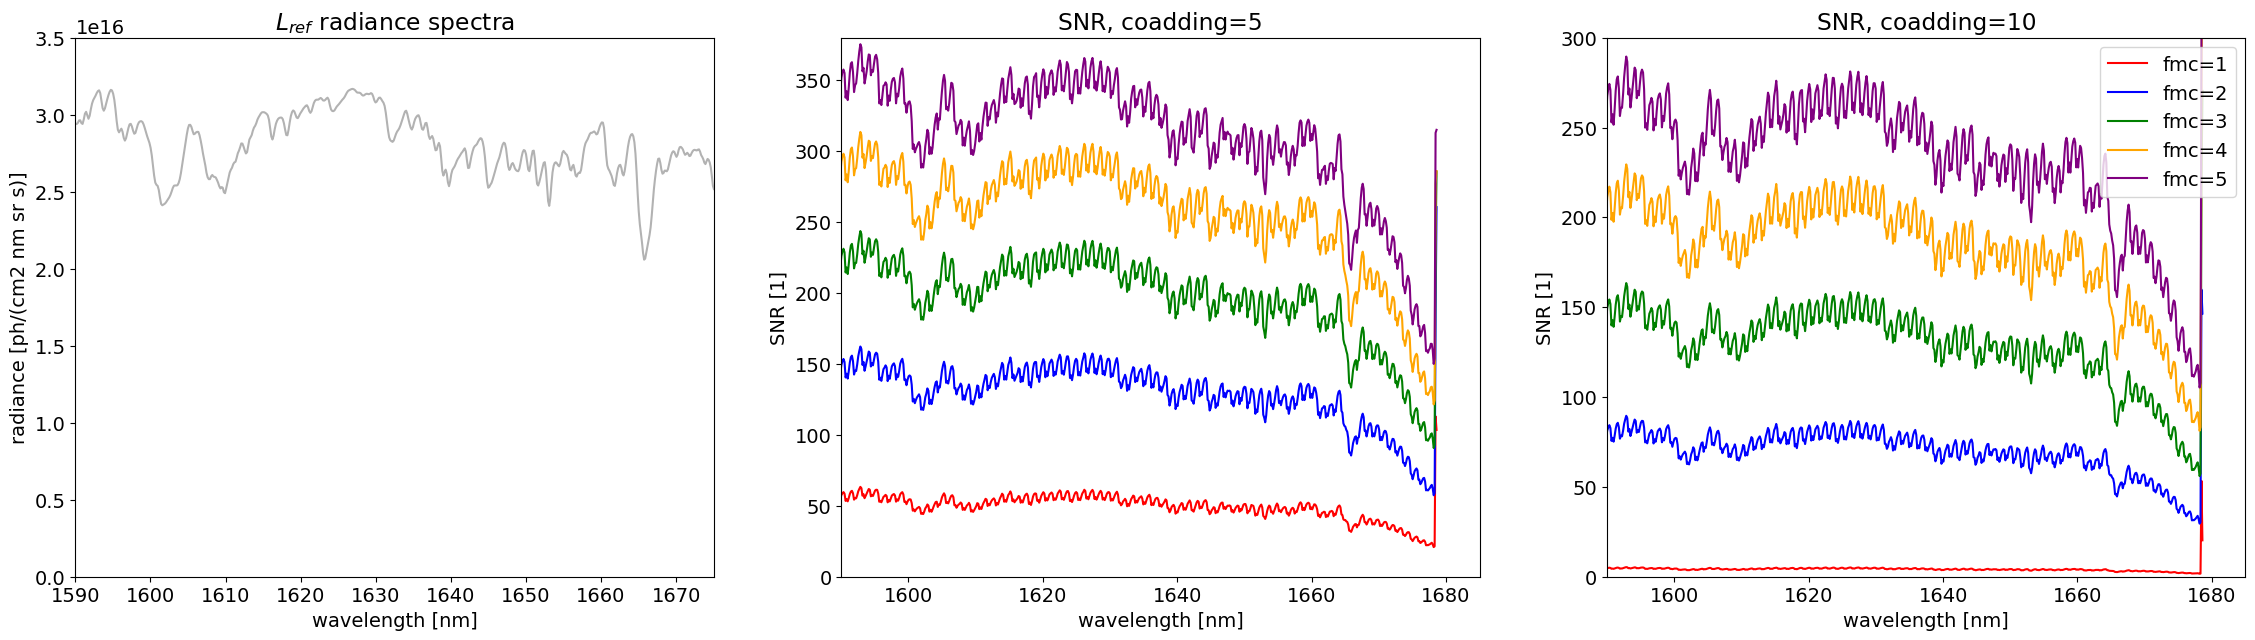

In [ ]:
nwave = 640
nfmc = 5
ncoadd = 2
wave_mean = np.zeros([ncoadd, nfmc, nwave])
rad_mean  = np.zeros([ncoadd, nfmc, nwave])
snr_mean  = np.zeros([ncoadd, nfmc, nwave])
plt.rcParams.update({'font.size': 14,})

coadd = [5, 10] #coadding 

for iadd in range(2):
    ccoadd = str_bcoeff = "%.1f" % (coadd[iadd])
    for fmc in range(nfmc):
        cfmc = str_bcoeff = "%.1f" % (fmc)
        ccoadd = str_bcoeff = "%.1f" % (coadd[iadd])

        filen = path+'level1b/Tango_Carbon_l1b_exp13_fmc'+cfmc+'_coadd'+ccoadd+'.nc'
        l1b_data = Dataset(filen)

        wave_mean[iadd,fmc,:] = np.mean(l1b_data['observation_data/wavelength'][:,:],axis=0)
        rad_mean[iadd,fmc,:]  = np.mean(l1b_data['observation_data/radiance'][0,:,:],axis=0)
        snr_mean[iadd,fmc,:]  = np.mean(l1b_data['observation_data/radiance'][0,:,:]/l1b_data['observation_data/radiance_stdev'][0,:,:],axis=0)

fig = plt.figure(figsize=(28, 7), dpi=100,)
ax0 = fig.add_subplot(131)
ax0.plot(wave_mean[0,0,:], rad_mean[0,0,:], color = 'grey', alpha = 0.6, label = 'lbl')
ax0.set_xlabel('wavelength [nm]')
ax0.set_ylabel('radiance [ph/(cm2 nm sr s)]')
ax0.set_ylim([0.0,3.5E16])
ax0.set_xlim([1590,1675])
ax0.set_title('$L_{ref}$ radiance spectra')
#ax0.legend()

ax1 = fig.add_subplot(132)
ax1.plot(wave_mean[0,0,:], snr_mean[0,0,:], color = 'red',    label = 'fmc=1',)
ax1.plot(wave_mean[0,1,:], snr_mean[0,1,:], color = 'blue',   label = 'fmc=2',)
ax1.plot(wave_mean[0,2,:], snr_mean[0,2,:], color = 'green',  label = 'fmc=3',)
ax1.plot(wave_mean[0,3,:], snr_mean[0,3,:], color = 'orange', label = 'fmc=4',)
ax1.plot(wave_mean[0,4,:], snr_mean[0,4,:], color = 'purple', label = 'fmc=5',)
ax1.set_xlim([1590,1685])
ax1.set_ylim([0.0,380])
ax1.set_title('SNR, coadding=5')
ax1.set_xlabel('wavelength [nm]')
ax1.set_ylabel('SNR [1]')

ax2 = fig.add_subplot(133)
ax2.plot(wave_mean[1,0,:], snr_mean[1,0,:], color = 'red',    label = 'fmc=1',)
ax2.plot(wave_mean[1,1,:], snr_mean[1,1,:], color = 'blue',   label = 'fmc=2',)
ax2.plot(wave_mean[1,2,:], snr_mean[1,2,:], color = 'green',  label = 'fmc=3',)
ax2.plot(wave_mean[1,3,:], snr_mean[1,3,:], color = 'orange', label = 'fmc=4',)
ax2.plot(wave_mean[1,4,:], snr_mean[1,4,:], color = 'purple', label = 'fmc=5',)
ax2.set_xlim([1590,1685])
ax2.set_ylim([0.0,300])
ax2.set_title('SNR, coadding=10')
ax2.set_xlabel('wavelength [nm]')
ax2.set_ylabel('SNR [1]')
ax2.legend()

### 8. L2 visualization

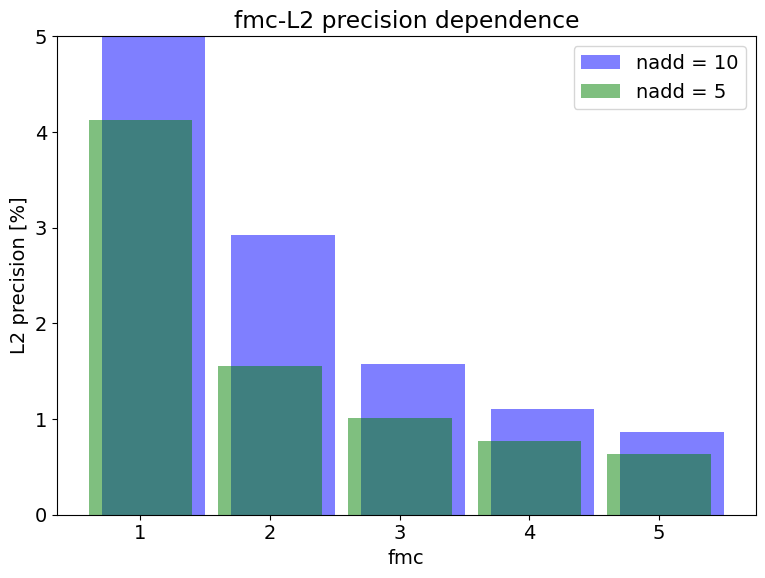

[4.12970695 1.55774233 1.01316047 0.7735164  0.63746893]
[51.2143434   2.91955167  1.57064713  1.10145158  0.86209075]


In [ ]:
nfmc = 5
ncoadd = 2
fmc_fact = np.arange(nfmc)+1
XCO2_ref = 410.
prec_xco2_proxy = np.zeros([ncoadd, nfmc])
plt.rcParams.update({'font.size': 14,})

coadd = [5, 10] #coadding 

for iadd in range(2):
    ccoadd = str_bcoeff = "%.1f" % (coadd[iadd])
    for fmc in range(nfmc):
        cfmc = str_bcoeff = "%.1f" % (fmc)
        ccoadd = str_bcoeff = "%.1f" % (coadd[iadd])

        l2filen = path+'level2/Tango_Carbon_l2_exp13_fmc'+cfmc+'_coadd'+ccoadd+'.nc'
        l2_data = Dataset(l2filen)
        prec_xco2_proxy[iadd,fmc] = np.mean(deepcopy(l2_data['precision XCO2 proxy'][:]).flatten())

plt.rcParams['font.size'] = 14
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(fmc_fact+0.1, prec_xco2_proxy[1,:]/XCO2_ref*100.,label = 'nadd = 10', color = 'blue', alpha = 0.5)
ax.bar(fmc_fact, prec_xco2_proxy[0,:]/XCO2_ref*100.,label = 'nadd = 5', color = 'green', alpha = 0.5)
ax.set_title('fmc-L2 precision dependence')
ax.set_xlabel('fmc')
ax.set_ylabel('L2 precision [%]')
ax.legend()
plt.tight_layout()
ax.set_ylim([0.0, 5])
plt.show()

print(prec_xco2_proxy[0,:]/XCO2_ref*100.)
print(prec_xco2_proxy[1,:]/XCO2_ref*100.)


### Conclusions
The analysis shows that
* fmc reduces the L2 precision well below 1 %. For fmc=5 and nadd=5, the predicted L2 proxy precision is 0.64 %. Coadding of 10 with a reduced integration time yields a L2 proxy precision of 0.86 %.
* The correspsonding SNR in the spectral continuum is ~350 and ~270, respectively.